<a href="https://colab.research.google.com/github/ShawnDong98/GAN/blob/master/WGAN-GP/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import  torch
from    torch import nn, optim, autograd
import  numpy as np
from    torch.nn import functional as F
from    matplotlib import pyplot as plt
import  random

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms

In [2]:
DIM = 128 # This overfits substantially; you're probably better off with 64
BATCH_SIZE = 4 # Batch size

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        preprocess = nn.Sequential(
            nn.Linear(128, 4 * 4 * 4 * DIM),
            #nn.BatchNorm2d(4 * 4 * 4 * DIM),  ## 他这里写错了
            nn.BatchNorm1d(4 * 4 * 4 * DIM),
            nn.ReLU(True),
        )

        block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * DIM, 2 * DIM, 2, stride=2),
            nn.BatchNorm2d(2 * DIM),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * DIM, DIM, 2, stride=2),
            nn.BatchNorm2d(DIM),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(DIM, 3, 2, stride=2)

        self.preprocess = preprocess
        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * DIM, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        return output.view(-1, 3, 32, 32)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        main = nn.Sequential(
            nn.Conv2d(3, DIM, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(DIM, 2 * DIM, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * DIM, 4 * DIM, 3, 2, padding=1),
            nn.LeakyReLU(),
        )

        self.main = main
        self.linear = nn.Linear(4*4*4*DIM, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*DIM)
        output = self.linear(output)
        return output

In [5]:
T = transforms.Compose([transforms.Resize((32, 32)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

dataset = datasets.ImageFolder(
    root = "../data/own_data/", 
    transform=T,
)
    
    


train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True,
    drop_last=True)


In [6]:
# 初始化
def weights_init(m):
    if isinstance(m, nn.Linear):
        # m.weight.data.normal_(0.0, 0.02)
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [7]:
# 生成GP优化
def gradient_penalty(D, xr, xf):
    """

    :param D:
    :param xr:
    :param xf:
    :return:
    """
    LAMBDA = 10

    # only constrait for Discriminator
    xf = xf.detach()
    xr = xr.detach()

    # [b, 1] => [b, 2]
    alpha = torch.rand(BATCH_SIZE, 1).cuda()
    alpha = alpha.expand(BATCH_SIZE, int(xr.nelement()/BATCH_SIZE)).reshape(BATCH_SIZE, 3, 32, 32)

    interpolates = alpha * xr + ((1 - alpha) * xf)
    interpolates.requires_grad_()

    disc_interpolates = D(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones_like(disc_interpolates),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA

    return gp

In [8]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# loader使用torchvision中自带的transforms函数
loader = transforms.Compose([
    transforms.ToTensor()])  

unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    print(image.size())
    image = image.squeeze(0)  # remove the fake batch dimension
    print(image.size())
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def toTensor(img):
    assert type(img) == np.ndarray,'the img type is {}, but ndarry expected'.format(type(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255).unsqueeze(0) 
    
def tensor_to_np(tensor):
    img = tensor.mul(255).byte()
    img = img.cpu().squeeze(0).numpy().transpose((1, 2, 0))
    return img
    
def show_from_tensor(tensor, title=None):
    img = tensor.clone()
    img = tensor_to_np(img)
    plt.figure()
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [9]:
torch.manual_seed(23)
np.random.seed(23)

G = Generator().cuda()
D = Discriminator().cuda()
G.apply(weights_init)
D.apply(weights_init)

optim_G = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.9))
optim_D = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.9))

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


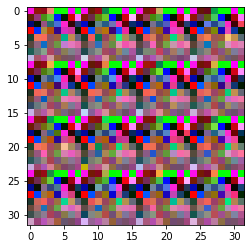

-35252.875 24944.16015625
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


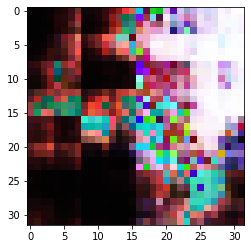

-3431.974609375 -109951.7890625
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


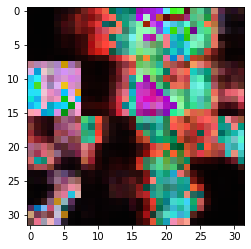

-22131.984375 -111089.7109375
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


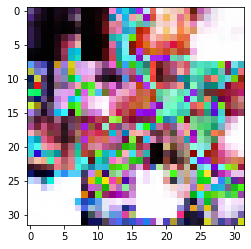

-9768.828125 -109006.2421875
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


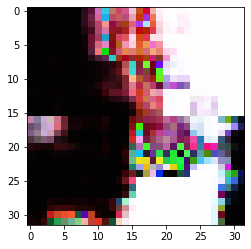

-9032.5068359375 -85279.75
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


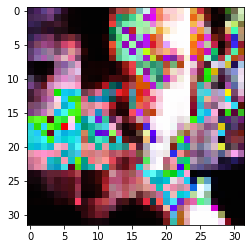

-9147.205078125 -64240.0390625
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


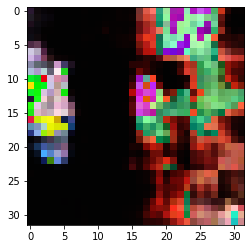

-13240.390625 -43856.703125
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


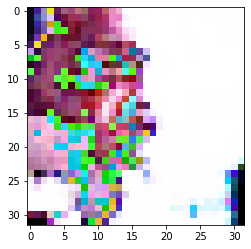

-16632.52734375 -39918.88671875
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


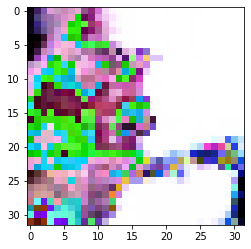

-7620.9248046875 -25587.04296875
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


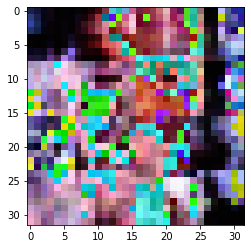

-16710.158203125 -24404.232421875
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


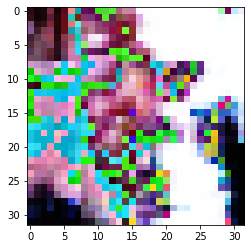

-21413.625 -18812.2578125
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


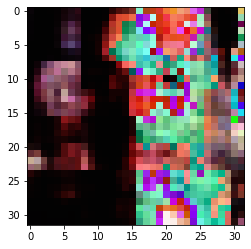

-19979.88671875 -12072.041015625


In [ ]:
for epoch in range(50000):
    for i, (data, _) in enumerate(train_loader):
        xr = data.cuda()

        predr = (D(xr))
        # max log(lossr)
        lossr = - (predr.mean())

        z = torch.randn(BATCH_SIZE, 128).cuda()
        # stop gradient on G

        xf = G(z).detach()

        predf = (D(xf))
        # min predf
        lossf = (predf.mean())

        # gradient penalty
        gp = gradient_penalty(D, xr, xf)

        loss_D = lossr + lossf + gp
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()
        
        if i%5==0:
            # 2. train Generator
            z = torch.randn(BATCH_SIZE, 128).cuda()
            xf = G(z)
            predf = (D(xf))
            # max predf
            loss_G = - (predf.mean())
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()
            
    if epoch % 10 == 0:
            with torch.no_grad():
                z = torch.randn(BATCH_SIZE, 128).cuda()
                xf = G(z)
            imshow(xf[0])
            print(loss_D.item(), loss_G.item())